In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
import keras_tuner as kt
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have Gated Recurrent Units(GRU). It's not known, which is better: GRU or LSTM because they have comparable performances. GRUs are easier to train than LSTMs.

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM.

In [10]:
# Load test dataset
test = pd.read_csv('/content/drive/MyDrive/Thesis_GoldPriceForecasting/Data/gold_price(2023)_preprocessed.csv')

# Load train dataset
train = pd.read_csv('/content/drive/MyDrive/Thesis_GoldPriceForecasting/Data/preprocessed_gold_price_train.csv')


In [11]:
train

,Date,Price,Open,High,Low,Volume,Change
0,2013-01-02,1689.9,1675.8,1695.00,1672.10,60.0,0.78
1,2013-01-03,1675.6,1688.0,1689.30,1664.30,190.0,-0.85
2,2013-01-04,1649.9,1664.4,1664.40,1630.00,310.0,-1.53
3,2013-01-07,1647.2,1657.3,1663.80,1645.30,90.0,-0.16
4,2013-01-08,1663.2,1651.5,1662.60,1648.80,130.0,0.97
...,...,...,...,...,...,...,...
2578,2022-12-26,1809.7,1805.8,1811.95,1805.55,20.0,0.30
2579,2022-12-27,1823.1,1808.2,1841.90,1808.00,159620.0,0.74
2580,2022-12-28,1815.8,1822.4,1822.80,1804.20,118080.0,-0.40
2581,2022-12-29,1826.0,1812.3,1827.30,1811.20,105990.0,0.56


In [12]:
test

,Date,Price,Open,High,Low,Volume,Change
0,2023-01-03,1846.1,1831.8,1856.6,1831.3,212270.0,1.09
1,2023-01-04,1859.0,1845.2,1871.3,1842.0,198350.0,0.70
2,2023-01-05,1840.6,1861.2,1864.3,1829.9,188600.0,-0.99
3,2023-01-06,1869.7,1835.9,1875.2,1835.2,215370.0,1.58
4,2023-01-09,1877.8,1872.8,1886.4,1869.3,204550.0,0.43
...,...,...,...,...,...,...,...
252,2023-12-22,2059.6,2051.5,2072.3,2049.4,440.0,0.87
253,2023-12-26,2060.4,2056.3,2069.6,2056.3,290.0,0.04
254,2023-12-27,2083.4,2068.0,2085.3,2063.3,590.0,1.12
255,2023-12-28,2083.5,2089.5,2098.2,2074.6,129540.0,0.00


In [13]:
# set index for train and test dataset
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

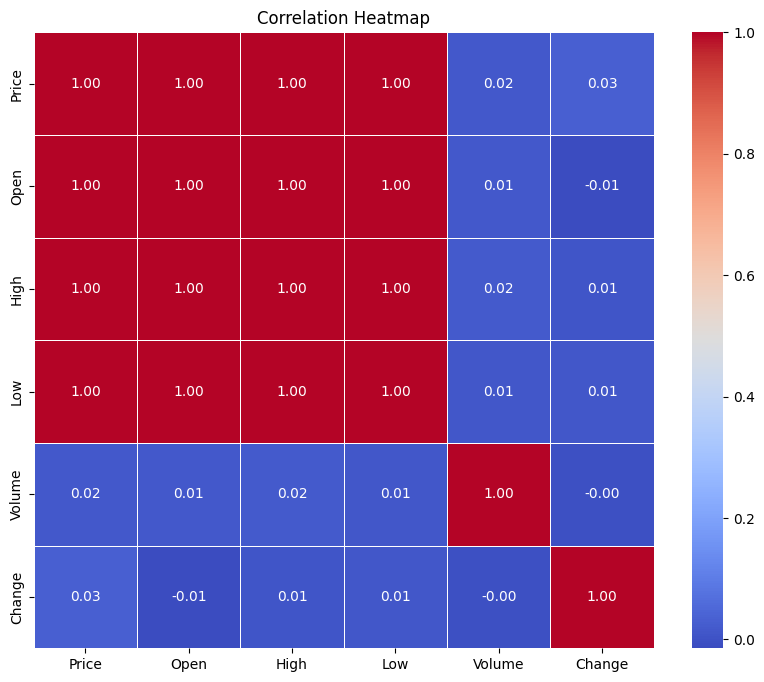

In [7]:
# Compute correlation matrix including the target
corr_matrix = train.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [17]:
n = len(train)
train_size = int(n * 0.8)

# Split the data, adjust train_size to leave data for validation
train_data = train.iloc[:train_size]
val_data = train.iloc[train_size:]

# MinMax scaling the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_data)
scaled_val = scaler.transform(val_data)
scaled_test = scaler.transform(test)


In [18]:
# Prepare the data for GRU: reshape into 3D for time series
window_size = 30
X_train_3d = []
y_train_3d = []

X_val_3d = []
y_val_3d = []

X_test_3d = []
y_test_3d = []
for i in range(window_size, len(scaled_train)):
    X_train_3d.append(scaled_train[i - window_size:i, 0]) # grabs a slice of 30 consecutive time steps
    y_train_3d.append(scaled_train[i, 0]) #  grabs the actual value at time i

for i in range(window_size, len(scaled_test)):
    X_val_3d.append(scaled_val[i - window_size:i, 0]) # grabs a slice of 30 consecutive time steps
    y_val_3d.append(scaled_val[i, 0]) #  grabs the actual value at time i

for i in range(window_size, len(scaled_test)):
    X_test_3d.append(scaled_test[i - window_size:i, 0]) # grabs a slice of 30 consecutive time steps
    y_test_3d.append(scaled_test[i, 0]) #  grabs the actual value at time i

# Turn the data into numpy array
X_train_3d = np.array(X_train_3d)
y_train = np.array(y_train_3d)
X_val_3d = np.array(X_val_3d)
y_val = np.array(y_val_3d)
X_test_3d = np.array(X_test_3d)
y_test = np.array(y_test_3d)


# Reshape the data into 3d
X_train = X_train_3d.reshape((X_train_3d.shape[0], X_train_3d.shape[1], 1))
X_val = X_val_3d.reshape((X_val_3d.shape[0], X_val_3d.shape[1], 1))
X_test = X_test_3d.reshape((X_test_3d.shape[0], X_test_3d.shape[1], 1))



In [28]:
# build the GRU model
def model_builder(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error', metrics=['mae'])
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(model_builder, objective='val_loss', max_trials=10, executions_per_trial=1, directory='my_dir', project_name='gru_tuning')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Perform the search
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hp.values}")

Trial 10 Complete [00h 00m 36s]
val_loss: 0.00022237225493881851

Best val_loss So Far: 0.00019255884399171919
Total elapsed time: 00h 07m 15s
Best Hyperparameters: {'units': 128, 'dropout_rate': 0.4, 'optimizer': 'adam'}


In [34]:
# Print the best number of units and learning rate
best_units = best_hp.get('units')
best_optimizer = best_hp.get('optimizer')

print(f"Best number of units: {best_units}")
print(f"Best optimizer: {best_optimizer}")



Best number of units: 128
Best optimizer: adam


the best optimizer is adam so the best learning rate should be 0.001

In [40]:
# Build the model with the best hyperparameters
best_model = model_builder(best_hp)

# Train the best model on the training data
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Train and predict
predictions = best_model.predict(X_test)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
# R-squared (R²) Score
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 0.0197 - mae: 0.1053 - val_loss: 5.0277e-04 - val_mae: 0.0187
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 2.3320e-04 - val_mae: 0.0120
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0020 - mae: 0.0338 - val_loss: 2.0800e-04 - val_mae: 0.0112
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - loss: 0.0021 - mae: 0.0335 - val_loss: 2.6652e-04 - val_mae: 0.0129
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0020 - mae: 0.0332 - val_loss: 4.3527e-04 - val_mae: 0.0175
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0017 - mae: 0.0311 - val_loss: 4.3499e-04 - val_mae: 0.0175
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0016 - mae: 0.0300 - val_loss: 1.9625e-04 - val_mae: 0.0110
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 3.3515e-04 - val_mae: 0.0149
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s

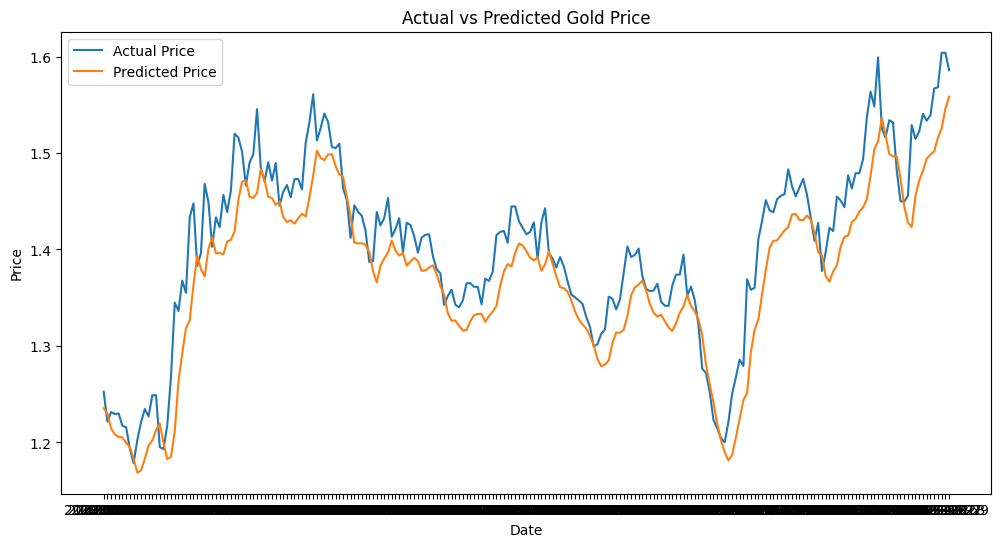

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[window_size:], y_test, label='Actual Price')
plt.plot(test.index[window_size:], predictions, label='Predicted Price')
plt.title('Actual vs Predicted Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()